In [1]:
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 500
from typing import Tuple, List, Any, Union, Iterator
from enum import IntEnum
from dataclasses import dataclass, field, InitVar, astuple
import warnings
import pandas as pd

%matplotlib inline

# Bandit Problem
The `Bandit` class is defined in the cell below. It contains all the relevent methods implementing the bandit algorithms to be compared:
- `pull(a)`: return the reward received when taking action `a`.
- `epsilon_greedy(epsilon, n_pulls, init)`: run the $\epsilon$-greedy algorithm.
- `ucb(c, n_pulls)`: run the UCB algorithm.
- `gradient_bandits(alpha, n_pulls, use_baseline)`: run the gradient bandits algorithm.
- `plot()`: draw violin plots of the reward distribution of each arm.

<ipython-input-2-ae828294386b>:166: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


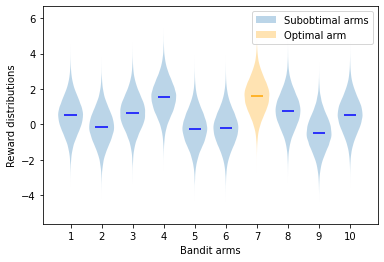

In [2]:
@dataclass(eq=False)
class Bandit(object):
    """Represents the multi-armed bandit.

    Args:
        k (int, optional): Number of arms. Defaults to 10.
        q_mean (float, optional): Mean of the normal distribution from which
            q-values are sampled. Defaults to 0.
        q_var (float, optional): Variance of the normal distribution from which
            q-values are sampled. Defaults to 1.
        reward_var (float, optional): Variance of the normal distribution from
            which rewards are sampled. Defaults to 1.
    """

    k: int = 10
    q_mean: InitVar[float] = 0
    q_var: InitVar[float] = 1
    reward_var: float = 1
    q: np.ndarray = field(init=False)

    def __post_init__(self, q_mean: float, q_var: float) -> None:
        self.q = np.random.normal(q_mean, q_var, self.k)

    def pull(self, a: int) -> float:
        return np.random.normal(self.q[a], self.reward_var)

    def epsilon_greedy(
        self, epsilon: float, n_pulls: int = 1000, init: float = 0
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Epsilon greedy algorithm.

        Args:
            epsilon (float): Constant real number in [0, 1].Controls the degree
                of exploration. Greedily choose the best estimated action w.p. 
                `epsilon`, and choose a random action w.p. 1 - `epsilon`.
            n_pulls (int, optional): Number of pulls in a run. Defaults to 1000.
            init (float, optional): Constant initialization value of the
                estimated Q values. Defaults to 0.

        Returns:
            np.ndarray: Estimated Q values.
            np.ndarray: Number of times each possible action was selected.
            np.ndarray: Reward received at each pull.
        """
        Q = np.full_like(self.q, init)
        N = np.zeros_like(self.q)
        rewards = []

        for _ in range(n_pulls):
            if np.random.random() < (1 - epsilon):
                # Random choice if multiple actions have the same value
                a = np.random.choice(np.argwhere(Q == np.max(Q)).flatten())
            else:
                a = np.random.randint(self.k)

            r = self.pull(a)
            N[a] += 1
            Q[a] += (r - Q[a]) / N[a]
            rewards.append(r)

        rewards = np.array(rewards)
        return Q, N, rewards

    def ucb(
        self, c: float, n_pulls: int = 1000
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Upper-Confidence-Bound algorithm.

        Args:
            c (float): Constant real number. Controls the degree of exploration.
            n_pulls (int, optional): Number of pulls in a run. Defaults to 1000.

        Returns:
            np.ndarray: Estimated Q values.
            np.ndarray: Number of times each possible action was selected.
            np.ndarray: Reward received at each pull.
        """
        Q = np.ones(self.k)
        N = np.zeros(self.k)
        rewards = []

        for t in range(n_pulls):
            # Return inf instead of nan when dividing by zero
            a = np.argmax(
                Q
                + c
                * np.sqrt(
                    np.divide(
                        np.log(t + 1),
                        N,
                        out=np.full_like(N, np.inf),
                        where=N != 0,
                    )
                )
            )
            r = self.pull(a)
            N[a] += 1
            Q[a] += (r - Q[a]) / N[a]
            rewards.append(r)

        rewards = np.array(rewards)
        return Q, N, rewards

    def gradient_bandits(
        self, alpha: float, n_pulls: int = 1000, use_baseline: bool = True
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Gradient bandits algorithm.

        Args:
            alpha (float): Step-size parameter.
            n_pulls (int, optional): Number of pulls in a run. Defaults to 1000.
            use_baseline (bool, optional): Whether to use a baseline reward. If
                True, the mean reward up to (and including) time t is used as
                the baseline. Defaults to True.

        Returns:
            np.ndarray: Estimated Q values.
            np.ndarray: Normalized probability distribution of choosing each
                possible action.
        """
        H = np.zeros(self.k)
        rewards = []

        for _ in range(n_pulls):
            p = np.exp(H) / np.sum(np.exp(H))
            a = np.random.choice(self.k, p=p)
            r = self.pull(a)
            rewards.append(r)
            one_hot = np.zeros(self.k)
            one_hot[a] = 1
            baseline = np.mean(rewards) if use_baseline else 0
            H += alpha * (r - baseline) * (one_hot - p)

        p = np.exp(H) / np.sum(np.exp(H))
        rewards = np.array(rewards)
        return p, rewards

    def plot(self) -> Tuple[plt.Figure, plt.Axes]:
        """Plot violin plots of the reward distribution of each bandit arm."""
        fig, ax = plt.subplots()
        # Sample many, many times from the reward distribution for a smooth curve
        violin_parts = ax.violinplot(
            [
                np.random.normal(mean, self.reward_var, size=100000)
                for mean in self.q
            ],
            widths=0.8,
            showmeans=True,
            showextrema=False,
        )
        max_idx = np.argmax(self.q)
        violin_parts["bodies"][max_idx].set_facecolor("orange")
        c = ["blue"] * self.k
        c[max_idx] = "orange"
        violin_parts["cmeans"].set_color(c)
        ax.set_xticks(np.arange(self.k) + 1)
        ax.set_xlabel("Bandit arms")
        ax.set_ylabel("Reward distributions")
        ax.legend(
            [
                violin_parts["bodies"][np.argmin(self.q)],
                violin_parts["bodies"][max_idx],
            ],
            ["Subobtimal arms", "Optimal arm"],
        )
        fig.show()

        return fig, ax

    def __eq__(self, other: Any) -> bool:
        """Override default method to account for `np.ndarray` fields.
        """
        if self is other:
            return True
        if not isinstance(other, Bandit):
            return False

        return all(
            self._array_safe_eq(a1, a2)
            for a1, a2 in zip(astuple(self), astuple(other))
        )

    @staticmethod
    def _array_safe_eq(a, b) -> bool:
        if a is b:
            return True
        if isinstance(a, np.ndarray) and isinstance(b, np.ndarray):
            return a.shape == b.shape and (a == b).all()
        return a == b


bandit = Bandit()
_ = bandit.plot()


In [3]:
n_runs = 2000
data = pd.DataFrame()

## $\epsilon$-greedy algorithm

<ipython-input-4-cbee8cef0e1d>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


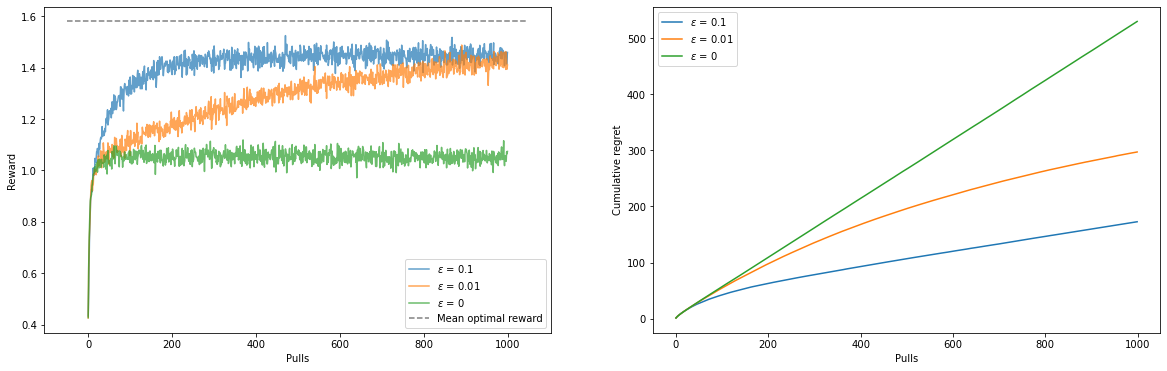

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for epsilon in [0.1, 0.01, 0]:
    rewards = []
    for _ in range(n_runs):
        Q, N, R = bandit.epsilon_greedy(epsilon)
        rewards.append(R)

    rewards = np.stack(rewards).mean(axis=0)
    axes[0].plot(rewards, label=f"$\\epsilon$ = {epsilon}", alpha=0.7)

    regret = (np.arange(len(rewards)) + 1) * bandit.q.max() - rewards.cumsum()
    axes[1].plot(regret, label=f"$\\epsilon$ = {epsilon}")

    data = data.append(
        {
            "Algorithm": "$\\epsilon$-greedy",
            "Pulls": len(regret),
            "$\\epsilon$": epsilon,
            "Max regret": regret.max(),
        },
        ignore_index=True,
    )

axes[0].hlines(
    bandit.q.max(),
    *axes[0].get_xlim(),
    colors="k",
    linestyles="dashed",
    label="Mean optimal reward",
    zorder=10,
    alpha=0.5,
)
axes[0].set_xlabel("Pulls")
axes[0].set_ylabel("Reward")
axes[0].legend()
axes[1].set_xlabel("Pulls")
axes[1].set_ylabel("Cumulative regret")
axes[1].legend()
fig.show()


<ipython-input-5-a00aeca32d66>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


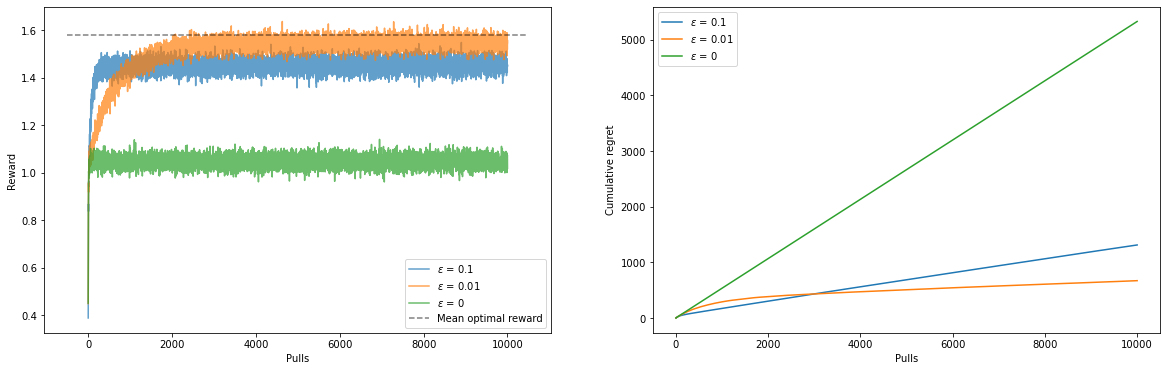

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for epsilon in [0.1, 0.01, 0]:
    rewards = []
    for _ in range(n_runs):
        Q, N, R = bandit.epsilon_greedy(epsilon, n_pulls=10000)
        rewards.append(R)

    rewards = np.stack(rewards).mean(axis=0)
    axes[0].plot(rewards, label=f"$\\epsilon$ = {epsilon}", alpha=0.7)

    regret = (np.arange(len(rewards)) + 1) * bandit.q.max() - rewards.cumsum()
    axes[1].plot(regret, label=f"$\\epsilon$ = {epsilon}")

    data = data.append(
        {
            "Algorithm": "$\\epsilon$-greedy",
            "Pulls": len(regret),
            "$\\epsilon$": epsilon,
            "Max regret": regret.max(),
        },
        ignore_index=True,
    )

axes[0].hlines(
    bandit.q.max(),
    *axes[0].get_xlim(),
    colors="k",
    linestyles="dashed",
    label="Mean optimal reward",
    zorder=10,
    alpha=0.5,
)
axes[0].set_xlabel("Pulls")
axes[0].set_ylabel("Reward")
axes[0].legend()
axes[1].set_xlabel("Pulls")
axes[1].set_ylabel("Cumulative regret")
axes[1].legend()
fig.show()


As expected, with $\epsilon$ = 0.1 and $\epsilon$ = 0.01 we have a higher final performance that with $\epsilon$ = 0. Allowing for some exploration makes it more likely we eventually find a better action. With $\epsilon$ = 0.01, it takes some time but we eventually reach an even higher performance that with $\epsilon$ = 0.1. The cumulative regret also seems to eventually flattens out, meaning we indeed have found the optimal solution. (Actually, the cumulative regret still has a small positive slope, as 1% of the time we choose an action at random, meaning we still choose suboptimal actions, which increases the regret).

Somewhat surprisingly however, even after averaging over 2000 runs, the reward is still quite noisy which is explained by the pretty high variance of the distribution from which it is sampled. 

<ipython-input-6-58f4cbcf4b06>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


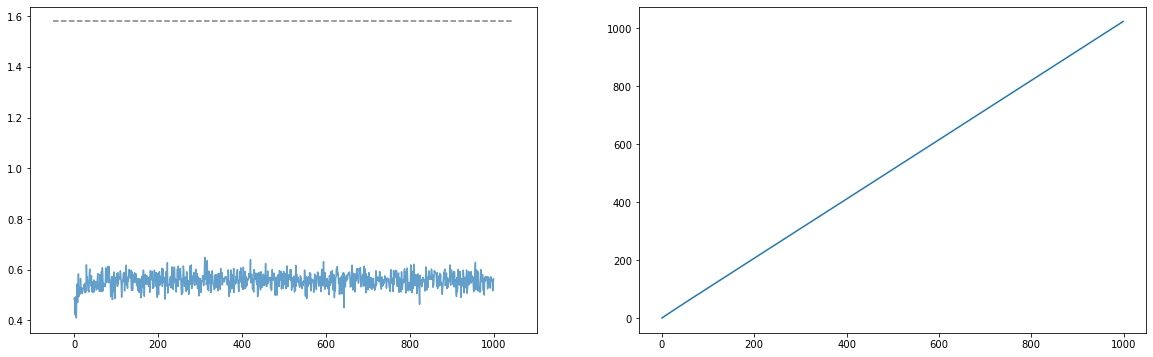

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

epsilon = 0.9
rewards = []
Qs = []
for _ in range(n_runs):
    Q, N, R = bandit.epsilon_greedy(epsilon)
    rewards.append(R)
    Qs.append(Q)

Qs = np.stack(Qs).mean(axis=0)
rewards = np.stack(rewards).mean(axis=0)
axes[0].plot(rewards, label=f"$\\epsilon$ = {epsilon}", alpha=0.7)
axes[0].hlines(
    bandit.q.max(),
    *axes[0].get_xlim(),
    colors="k",
    linestyles="dashed",
    label="Mean optimal reward",
    zorder=10,
    alpha=0.5,
)

regret = (np.arange(len(rewards)) + 1) * bandit.q.max() - rewards.cumsum()
axes[1].plot(regret, label=f"$\\epsilon$ = {epsilon}")
fig.show()

data = data.append(
    {
        "Algorithm": "$\\epsilon$-greedy",
        "Pulls": len(regret),
        "$\\epsilon$": epsilon,
        "Max regret": regret.max(),
    },
    ignore_index=True,
)



Setting the value of $\epsilon$ at 0.9 is a very bad choice in the current setting. Indeed, the agent would spend 90% of its time exploring the action space instead of exploring. We must note however that the runs are long enough that the agent is still able to learn quite well the mean reward given by each arm. The problem here is that the balance between exploration and exploitation is really badly chosen.

In [7]:
print("Learned Q values:  ", *list(map("{:.3f}".format, Qs)))
print("True mean q values:", *list(map("{:.3f}".format, bandit.q)))


Learned Q values:   0.495 -0.138 0.646 1.514 -0.234 -0.240 1.565 0.763 -0.473 0.543
True mean q values: 0.497 -0.138 0.648 1.523 -0.234 -0.234 1.579 0.767 -0.469 0.543


## Optimistic initial value
To run the optimistic initial value algorithm, we can reuse the same method as for the $\epsilon$-greedy algorithm, but this time using the `init` parameter and setting $\epsilon$ to 0.

<ipython-input-8-71a8017b532c>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


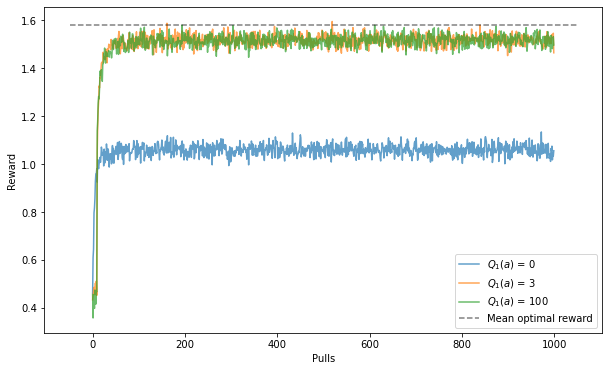

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for init in [0, 3, 100]:
    rewards = []
    for _ in range(n_runs):
        Q, N, R = bandit.epsilon_greedy(0, init=init)
        rewards.append(R)

    rewards = np.stack(rewards).mean(axis=0)
    ax.plot(rewards, label=f"$Q_1(a)$ = {init}", alpha=0.7)

    regret = (np.arange(len(rewards)) + 1) * bandit.q.max() - rewards.cumsum()
    data = data.append(
        {
            "Algorithm": "Optimistic initial value",
            "Pulls": len(regret),
            "Initial value": init,
            "Max regret": regret.max(),
        },
        ignore_index=True,
    )

ax.hlines(
    bandit.q.max(),
    *ax.get_xlim(),
    colors="k",
    linestyles="dashed",
    label="Mean optimal reward",
    zorder=10,
    alpha=0.5,
)
ax.set_xlabel("Pulls")
ax.set_ylabel("Reward")
ax.legend()
fig.show()


As expected, using an optimistic initial value for our $Q$ estimates is very effective even with a greedy algorithm, as it forces the agent to explore the action space. However, given the range of rewards, we don't get any improvement by setting $Q_1(a)$ to anything higher than 3. If the $q_\ast$ values had been sampled differently, such that their scale was much larger, then it might have been useful, but here there is no point.

## UCB algorithm

<ipython-input-9-448a4bf6c283>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


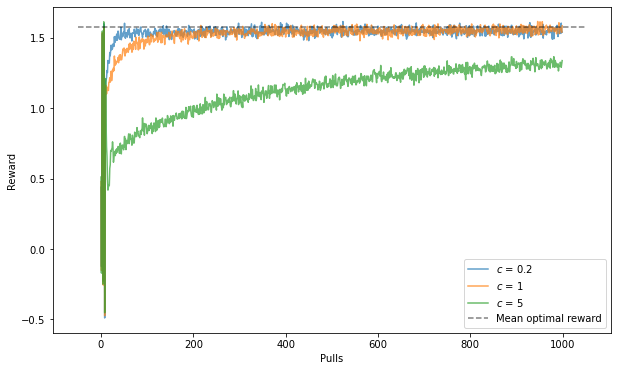

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for c in [0.2, 1, 5]:
    rewards = []
    for _ in range(n_runs):
        Q, N, R = bandit.ucb(c)
        rewards.append(R)

    rewards = np.stack(rewards).mean(axis=0)
    ax.plot(rewards, label=f"$c$ = {c}", alpha=0.7)

    regret = (np.arange(len(rewards)) + 1) * bandit.q.max() - rewards.cumsum()
    data = data.append(
        {
            "Algorithm": "UCB",
            "Pulls": len(regret),
            "c": c,
            "Max regret": regret.max(),
        },
        ignore_index=True,
    )

ax.hlines(
    bandit.q.max(),
    *ax.get_xlim(),
    colors="k",
    linestyles="dashed",
    label="Mean optimal reward",
    zorder=10,
    alpha=0.5,
)
ax.set_xlabel("Pulls")
ax.set_ylabel("Reward")
ax.legend()
fig.show()


As expected, the UCB algorithm is very effective as well. With values of $c$ of 0.2 and 1, we get enough exploration to quickly find the best arm (with $c$ = 1 ever so slightly behind $c$ = 0.2). The reward then stays quite stable through out the runs.

With $c$ = 5, we have too much exploration, which substantially slows down the exploitation of the optimal arm. However, the agent still gradually catches up to the performance of runs with a lower $c$.

Note the spike early in the experiment. This happens while the agent does a first round robin pass through its actions. Since none of them have been selected, the UCB procedure will select them at least once (we divide by 0, which gives $\infty$, and $\max\{\cdot, \infty\} = \infty$). When we get to the optimal arm, we indeed get a high reward. Afterwards, the reward drops because the uncertainty term forces exploration, until each action has been selected enough to reduce the uncertainty for each arm.

## Gradient bandit

<ipython-input-10-5358814e3545>:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


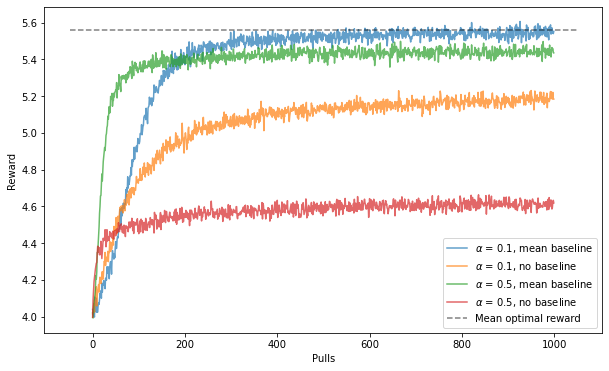

In [10]:
new_bandit = Bandit(q_mean=4)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

for alpha in [0.1, 0.5]:
    for use_baseline in [True, False]:
        rewards = []
        for _ in range(n_runs):
            H, R = new_bandit.gradient_bandits(alpha, use_baseline=use_baseline)
            rewards.append(R)

        rewards = np.stack(rewards).mean(axis=0)
        ax.plot(
            rewards,
            label=f"$\\alpha$ = {alpha}, {'mean baseline' if use_baseline else 'no baseline'}",
            alpha=0.7,
        )

        regret = (
            np.arange(len(rewards)) + 1
        ) * new_bandit.q.max() - rewards.cumsum()
        data = data.append(
            {
                "Algorithm": "Gradient bandits",
                "Pulls": len(regret),
                "$\\alpha$": alpha,
                "Baseline": "Mean baseline" if use_baseline else "No baseline",
                "Max regret": regret.max(),
            },
            ignore_index=True,
        )

ax.hlines(
    new_bandit.q.max(),
    *ax.get_xlim(),
    colors="k",
    linestyles="dashed",
    label="Mean optimal reward",
    zorder=10,
    alpha=0.5,
)
ax.set_xlabel("Pulls")
ax.set_ylabel("Reward")
ax.legend()
fig.show()


As expected, having a baseline reward substantially improves the performance for both values of $\alpha$ tested. Indeed, with no baseline (or rather a baseline of 0) preferences for actions with a lesser performance are not pushed down quite as much as when we compare them to the mean reward (and vice-versa for better performing actions).

A larger value of $\alpha$ leads to a quicker initial exploration with bigger a step-size to update preferences, but only the algorithm with baseline is able to capitalize on it. Still with a baseline but with a smaller step-size, we eventually reach the same performance, but later on.

Finally, with large $\alpha$ and no basline is where we get the worst performance. In terms of optimization, we are probably bouncing around the optimum by taking too large steps in the gradient ascent procedure.

## Comparing bandit algorithms

In [11]:
data["Pulls"] = data["Pulls"].astype("int")
data["Max regret per pull"] = data["Max regret"] / data["Pulls"]
data = data[["Algorithm"] +
    [c for c in data if c not in ["Algorithm", "Max regret", "Max regret per pull"]]
    + ["Max regret", "Max regret per pull"]
]

In [12]:
print("Results, sorted by max regret")
data.sort_values("Max regret", ignore_index=True)

Results, sorted by max regret


,Algorithm,$\epsilon$,Pulls,Initial value,c,$\alpha$,Baseline,Max regret,Max regret per pull
0,UCB,NaN,1000,NaN,0.2,NaN,NaN,49.439860,0.049440
1,UCB,NaN,1000,NaN,1.0,NaN,NaN,63.566621,0.063567
2,Optimistic initial value,NaN,1000,3.0,NaN,NaN,NaN,75.668392,0.075668
3,Optimistic initial value,NaN,1000,100.0,NaN,NaN,NaN,77.084477,0.077084
4,$\epsilon$-greedy,0.10,1000,NaN,NaN,NaN,NaN,172.708994,0.172709
5,Gradient bandits,NaN,1000,NaN,NaN,0.5,Mean baseline,175.736483,0.175736
6,Gradient bandits,NaN,1000,NaN,NaN,0.1,Mean baseline,177.270477,0.177270
7,$\epsilon$-greedy,0.01,1000,NaN,NaN,NaN,NaN,297.147593,0.297148
8,UCB,NaN,1000,NaN,5.0,NaN,NaN,457.002763,0.457003
9,Optimistic initial value,NaN,1000,0.0,NaN,NaN,NaN,523.165562,0.523166


In [13]:
print("Results, sorted by max regret normalized by number of pulls")
data.sort_values("Max regret per pull", ignore_index=True)

Results, sorted by max regret normalized by number of pulls


,Algorithm,$\epsilon$,Pulls,Initial value,c,$\alpha$,Baseline,Max regret,Max regret per pull
0,UCB,NaN,1000,NaN,0.2,NaN,NaN,49.439860,0.049440
1,UCB,NaN,1000,NaN,1.0,NaN,NaN,63.566621,0.063567
2,$\epsilon$-greedy,0.01,10000,NaN,NaN,NaN,NaN,670.835803,0.067084
3,Optimistic initial value,NaN,1000,3.0,NaN,NaN,NaN,75.668392,0.075668
4,Optimistic initial value,NaN,1000,100.0,NaN,NaN,NaN,77.084477,0.077084
5,$\epsilon$-greedy,0.10,10000,NaN,NaN,NaN,NaN,1312.092786,0.131209
6,$\epsilon$-greedy,0.10,1000,NaN,NaN,NaN,NaN,172.708994,0.172709
7,Gradient bandits,NaN,1000,NaN,NaN,0.5,Mean baseline,175.736483,0.175736
8,Gradient bandits,NaN,1000,NaN,NaN,0.1,Mean baseline,177.270477,0.177270
9,$\epsilon$-greedy,0.01,1000,NaN,NaN,NaN,NaN,297.147593,0.297148


In terms of absolute cumulative regret, the UCB algorithm is the best performer of all the algorithms tested here. Then follow optimistic initial value, gradient bandits, and finally $\epsilon$-greedy. These results are indeed consistent with those reported in Sutton \& Barto (2018).

However, if we look at cumulative regret on a per-pull basis, while UCB stays the best, $\epsilon$-greedy (with  $\epsilon$ = 0.01) run over 10,000 pulls achieves a very good performance, almost as good as UCB. Indeed, looking at the regret plot for $\epsilon$ = 0.01 over 10,000 pulls, the curve flattens out as time goes on. If our training time is irrelevent (for example if the agent will be deployed for much longer time than it takes for training) then this could be a good option to explore, otherwise other algorithms should be used instead.

Finally, even though UCB works really well on the current test case, we must note its effectiveness would be limited in settings with a large state space. Since actions are chosen inversely proportionnally to the number of times they have been selected in the past, each of them will be selected at least once early on in each run (none of them has been selected at first, and $\max\{\cdot, 1/0\} = \infty$). This isn't a problem with 10 possible actions like we have here, but with a very large action/state space, UCB might become really impractical while it does a first "round-robin" pass.

# Dynamic Programming

In [2]:
class Directions(IntEnum):
    RIGHT = 0
    UP = 1
    LEFT = 2
    DOWN = 3


@dataclass
class State(object):
    y: int
    x: int


@dataclass
class GridWorld(object):
    shape: Tuple[int, int]  # (H, W)
    terminal_states: List[State]
    state: State = field(init=False)

    def __post_init__(self):
        # Choose starting position at random
        self.randomize_state()

    def randomize_state(self):
        # Pseudo do-while
        first_pass = True
        while first_pass or self.state in self.terminal_states:
            first_pass = False
            self.state = State(*np.random.randint(self.shape))

    def move(self, direction: int) -> Tuple[float, bool]:
        new_state, reward, game_over = self.move_from(self.state, direction)
        self.state = new_state
        return reward, game_over

    def move_from(
        self, state: State, direction: int
    ) -> Tuple[State, float, bool]:
        y, x = state.y, state.x
        if direction == Directions.UP:
            y = max(state.y - 1, 0)
        elif direction == Directions.DOWN:
            y = min(state.y + 1, self.shape[0] - 1)
        elif direction == Directions.LEFT:
            x = max(state.x - 1, 0)
        elif direction == Directions.RIGHT:
            x = min(state.x + 1, self.shape[1] - 1)

        new_state = State(y, x)
        reward = -1
        game_over = new_state in self.terminal_states
        return new_state, reward, game_over

    def sweep(self) -> Iterator[State]:
        """Sweeps the grid world over its whole state space.

        Yields:
            State: A state of the grid world.
        """
        for y in range(self.shape[0]):
            for x in range(self.shape[1]):
                yield State(y, x)


gw = GridWorld((5, 5), [State(0, 0), State(4, 4)])


In [3]:
def policy_iteration(
    gw: GridWorld, V_init: Union[float, np.ndarray], theta: float
) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
    """Runs the policy iteration algorithm on grid world `gw`.

    Args:
        gw (GridWorld): Grid world object.
        V_init (Union[float, np.ndarray]): Initial values estimate. Can 
            either be a constant or an array of shape `gw.shape`.
        theta (float): Small positive number, the accuracy threshold to 
            exit the evaluation loop.

    Yields:
        Tuple[np.ndarray, np.ndarray]: A tuple containing arrays of the 
            estimated values and the estimated optimal policy. Each tuple
            is yielded at the beginning of the loop until convergence is
            reached.
    """
    if isinstance(V_init, (int, float)):
        V = np.full(gw.shape, V_init)
    elif isinstance(V_init, np.ndarray):
        V = V_init
    else:
        raise TypeError(
            f"Got unexpected type f{type(V_init)} for argument V_init."
        )

    # Start with uniform policy
    pi = np.ones((*gw.shape, len(Directions)))
    pi /= pi.sum(axis=-1, keepdims=True)

    policy_stable = False
    while not policy_stable:
        # Yield at the beginning of each loop (the last two should be 
        # identical, +/- theta)
        yield V.copy(), pi.copy()
        policy_evaluation(gw, V, pi, theta)
        policy_stable = policy_improvement(gw, V, pi)


def policy_evaluation(
    gw: GridWorld, V: np.array, pi: np.array, theta: float
) -> None:
    """Evaluates policy `pi` and updates state values `V` in-place.

    Args:
        gw (GridWorld): Grid world object.
        V (np.array): Values of each state on the grid world
        pi (np.array): Policy to evaluate.
        theta (float): Small positive number, the accuracy threshold to
            exit the evaluation loop.
    """
    delta = (
        np.inf
    )  # Initialize delta as infinite to enter the loop for the first time
    while delta >= theta:
        delta = 0
        old_V = V.copy()
        for state in gw.sweep():
            if state in gw.terminal_states:
                V[astuple(state)] = 0  # Value of 0 on terminal states
                continue

            total = 0
            for direction in Directions:
                new_state, reward, _ = gw.move_from(state, direction)
                total += pi[(*astuple(state), direction)] * (
                    reward + old_V[astuple(new_state)]
                )

            V[astuple(state)] = total

        # Compute delta over the whole arrays
        delta = np.maximum(delta, np.abs(old_V - V)).max()


def policy_improvement(gw: GridWorld, V: np.array, pi: np.array) -> bool:
    """Improves the policy `pi` and updates it in-place.

    Args:
        gw (GridWorld): Grid world object.
        V (np.array): Values of each state on the grid world.
        pi (np.array): Policy to update.

    Returns:
        bool: Whether the policy is stable or it has changed.
    """
    old_pi = pi.copy()
    for state in gw.sweep():
        best_actions = []
        max_v = -np.inf
        for direction in Directions:
            new_state, reward, _ = gw.move_from(state, direction)
            v = reward + V[astuple(new_state)]

            # Find all best actions
            if v > max_v:
                max_v = v
                best_actions = [direction]
            elif v == max_v:
                best_actions.append(direction)

        # Assign uniform probability to the best actions, 0 otherwise
        p = 1 / len(best_actions)
        for direction in Directions:
            pi[(*astuple(state), direction)] = (
                p if direction in best_actions else 0
            )

    # Check if policy is stable
    return np.all(old_pi == pi)


def run_policy(
    gw: GridWorld, pi: np.ndarray, randomize_state=True
) -> Tuple[float, int]:
    """Runs an episode on the grid world `gw` following policy `pi`.
    
    Args:
        gw (GridWorld): Grid world object.
        pi (np.array): Policy to update.
        randomize_state (bool): Wheter to randomize the starting state on 
            the grid world. The state can be set before calling this function
            by accessing `gw.state`. Defaults to True.
    
    Returns:
        float: The cumulative reward over the episode.
        int: The number of steps to solve the task.
    """
    if randomize_state:
        gw.randomize_state()

    game_over = False
    cum_reward = 0
    steps = 0
    while not game_over:
        direction = np.random.choice(len(Directions), p=pi[astuple(gw.state)])
        r, game_over = gw.move(direction)
        cum_reward += r
        steps += 1

    return cum_reward, steps


In [4]:
def value_iteration(
    gw: GridWorld, V_init: Union[float, np.ndarray], theta: float
) -> Iterator[np.ndarray]:
    """Runs the value iteration algorithm on grid world `gw`.

    Args:
        gw (GridWorld): Grid world object.
        V_init (Union[float, np.ndarray]): Initial values estimate. Can 
            either be a constant or an array of shape `gw.shape`.
        theta (float): Small positive number, the accuracy threshold to 
            exit the loop.

    Yields:
        np.ndarray: Estimated values. Each array is yielded at the beginning
            of the loop until convergence is reached.
    """
    if isinstance(V_init, (int, float)):
        V = np.full(gw.shape, V_init)
    elif isinstance(V_init, np.ndarray):
        V = V_init
    else:
        raise TypeError(
            f"Got unexpected type f{type(V_init)} for argument V_init."
        )

    if any(V[astuple(terminal)] != 0 for terminal in gw.terminal_states):
        warnings.warn(
            f"Overwriting initial value on terminal states {gw.terminal_states} from "
            f"{[V[astuple(terminal)] for terminal in gw.terminal_states]} to 0."
        )
        for terminal in gw.terminal_states:
            V[astuple(terminal)] = 0

    delta = (
        np.inf
    )  # Initialize delta as infinite to enter the loop for the first time
    while delta >= theta:
        # Yield at the beginning of each loop (the last two should be
        # identical, +/- theta)
        yield V.copy()

        delta = 0
        old_V = V.copy()
        for state in gw.sweep():
            if state in gw.terminal_states:
                continue  # Skip terminal states

            max_v = -np.inf
            for direction in Directions:
                new_state, reward, _ = gw.move_from(state, direction)
                v = reward + V[astuple(new_state)]
                max_v = max(v, max_v)

            V[astuple(state)] = max_v

        delta = np.maximum(delta, np.abs(old_V - V)).max()


def run_greedy_values(
    gw: GridWorld, V: np.ndarray, randomize_state=True
) -> Tuple[float, int]:
    """Runs an episode on the grid world `gw` the greedy policy using state 
    values `V`. If more than one action leads to states that have the same 
    maximal value, the action is chosen randomly.
    
    Args:
        gw (GridWorld): Grid world object.
        V (np.array): Values of each state on the grid world.
        randomize_state (bool): Wheter to randomize the starting state on 
            the grid world. The state can be set before calling this function
            by accessing `gw.state`. Defaults to True.
    
    Returns:
        float: The cumulative reward over the episode.
        int: The number of steps to solve the task.
    """
    if randomize_state:
        gw.randomize_state()

    game_over = False
    cum_reward = 0
    steps = 0
    while not game_over:
        values = []
        for d in Directions:
            new_state, reward, _ = gw.move_from(gw.state, d)
            values.append(reward + V[astuple(new_state)])

        direction = np.random.choice(
            np.argwhere(values == np.max(values)).flatten()
        )
        # direction = np.argmax(values)
        r, game_over = gw.move(direction)
        steps += 1
        cum_reward += r

    return cum_reward, steps


To compute $q_\pi(11, \texttt{down})$ and $q_\pi(7, \texttt{down})$, we can use the relationship between $q_\pi(s, a)$ and $v_\pi(s)$:
$$q_\pi(s, a) = \sum_{s', r} p(s', r \mid s, a) [r + \gamma v_\pi(s')]$$

Given the MDP dynamics, we therefore have
$$q_\pi(11, \texttt{down}) = -1 + v_\pi(16)$$
$$q_\pi(7, \texttt{down}) = -1 + v_\pi(12)$$

We can use our function `policy_evaluation` to compute $v_\pi(16)$ and $v_\pi(12)$.

In [17]:
V = np.full(gw.shape, 0)
pi = np.ones((*gw.shape, len(Directions)))
pi /= pi.sum(axis=-1, keepdims=True)
policy_evaluation(gw, V, pi, 0.01)
print("v_pi(16) =", V[16 // gw.shape[1], 16 % gw.shape[1]])
print("v_pi(12) =", V[12 // gw.shape[1], 12 % gw.shape[1]])

v_pi(16) = -14
v_pi(12) = -14


We therefore have $q_\pi(11, \texttt{down}) = q_\pi(7, \texttt{down}) = -15$.

Regarding the optimal policy, my hypothesis is that it would look something like the following. All arrows coming *out* of a cell represent equiprobable actions. Since there are many different equivalent paths towards the terminal states, the optimal policy would simply choose one that minimizes the number of steps to get to one of them. For example cells on the anti-diagonal are the same distance away from either terminal state, so it doesn't matter which one we choose, but once that choice is made there is no going back towards the other one, somewhat like a hydrological watershed line.

<ipython-input-18-db2f9d815e01>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


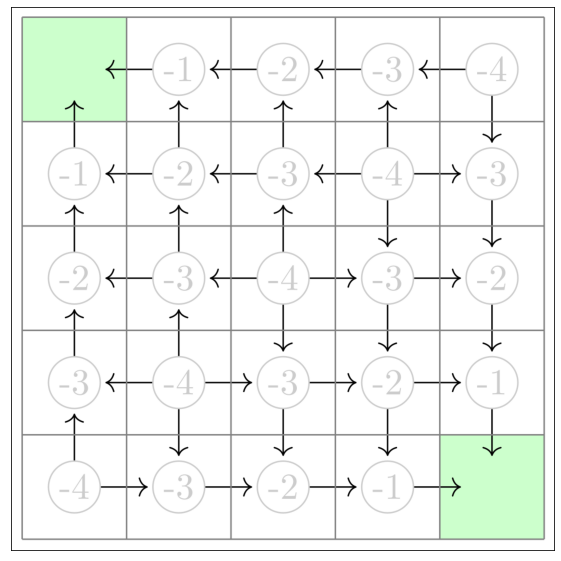

In [18]:
grid_img = plt.imread("grid.png")
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grid_img)
ax.set_xticks([])
ax.set_yticks([])
fig.show()

In [5]:
# General parameters
theta = 0.1
V_init = 0
n_episodes = 5
n_seeds = 5

## Policy iteration

In [21]:
for i, (V, pi) in enumerate(policy_iteration(gw, V_init, theta)):
    print(f"Value and policiy estimates with policy iteration after {i} loops:")
    print("- Value function")
    print(V)
    for direction in Directions:
        print("-", direction.name.capitalize())
        print(pi[:, :, direction])
    
    print(f"Results after {i} loops:")
    for seed in range(n_seeds):
        gw.randomize_state()
        starting_state = gw.state
        rewards = []
        steps = []
        for _ in range(n_episodes):
            gw.state = starting_state
            r, s = run_policy(gw, pi, randomize_state=False)
            rewards.append(r)
            steps.append(s)
        
        print(f"- Starting from state {astuple(starting_state)}, got reward {rewards} " 
              f"in {steps} steps respectively.")

    print("\n", "-"*20, "\n")

Value and policiy estimates with policy iteration after 0 loops:
- Value function
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
- Right
[[0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]]
- Up
[[0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]]
- Left
[[0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]]
- Down
[[0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25 0.25]]
Results after 0 loops:
- Starting from state (3, 0), got reward [-12, -50, -4, -10, -14] in [12, 50, 4, 10, 14] steps respectively.
- Starting from state (0, 3), got reward [-74, -47, -33, -70, -49] in [74, 47, 33, 70, 49] steps respectively.
- Starting from st

## Value iteration

In [20]:
for i, V in enumerate(value_iteration(gw, V_init, theta)):
    print(f"Value estimates with value iteration after {i} loops")
    print(V)
    
    print(f"Results after {i} loops:")
    for _ in range(n_seeds):
        gw.randomize_state()
        starting_state = gw.state
        rewards = []
        steps = []
        for _ in range(n_episodes):
            gw.state = starting_state  # Reset state
            r, s = run_greedy_values(gw, V, randomize_state=False)
            rewards.append(r)
            steps.append(s)
        
        print(f"- Starting from state {astuple(starting_state)}, got reward {rewards} " 
              f"in {steps} steps respectively.")
    
    print("\n", "-"*20, "\n")

Value estimates with value iteration after 0 loops
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]
Results after 0 loops:
- Starting from state (1, 0), got reward [-1, -56, -30, -37, -27] in [1, 56, 30, 37, 27] steps respectively.
- Starting from state (0, 3), got reward [-8, -6, -4, -9, -19] in [8, 6, 4, 9, 19] steps respectively.
- Starting from state (4, 3), got reward [-1, -1, -23, -1, -1] in [1, 1, 23, 1, 1] steps respectively.
- Starting from state (2, 2), got reward [-39, -12, -8, -18, -38] in [39, 12, 8, 18, 38] steps respectively.
- Starting from state (2, 4), got reward [-24, -21, -6, -74, -74] in [24, 21, 6, 74, 74] steps respectively.

 -------------------- 

Value estimates with value iteration after 1 loops
[[ 0 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0]]
Results after 1 loops:
- Starting from state (1, 4), got reward [-3, -10, -3, -7, -7] in [3, 10, 3, 7, 7] steps respectively.
- Starting from state (1, 3), got 

In [22]:
%timeit list(policy_iteration(gw, V_init, theta))
%timeit list(value_iteration(gw, V_init, theta))

74.4 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.9 ms ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
V, pi = list(policy_iteration(gw, V_init, theta))[-1]

%timeit run_policy(gw, pi)
%timeit run_greedy_values(gw, V)

199 µs ± 4.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
383 µs ± 5.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Comparing value iteration and policy iteration
As expected, both algorithms converge to the same value function, which also corresponds to the value function I hypothesised. In terms of run time, value iteration takes more loops to converge than policy interation (4 instead of 2), but since each of those loops in much shorter, value iteration is about an order of magnitude faster than policy iteration. One thing of note however is that policy iteration is able here to learn *an* optimal policy after only one loop, despite not having properly learned the correct value function yet.

Running the greedy policy using the value estimates $V$ is about twice as long as following the policy $\pi$ learned by policy iteration, but this run time is degligible compared to the time it takes to actually learn the values and policy.

Comparing policies, they are identical for both algorithms. For the greedy policy used following value iteration, we choose randomly from neighbooring states that have the highest value, which we can see is equivalent to the policy learned by policy iteration.

On this task, value iteration is therefore the best choice.